# Installations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/haotian-liu/LLaVA.git@786aa6a19ea10edc6f574ad2e16276974e9aaa3a

  Cloning https://github.com/haotian-liu/LLaVA.git (to revision 786aa6a19ea10edc6f574ad2e16276974e9aaa3a) to /tmp/pip-req-build-_tc_klfa
  Running command git clone --filter=blob:none --quiet https://github.com/haotian-liu/LLaVA.git /tmp/pip-req-build-_tc_klfa
  Running command git rev-parse -q --verify 'sha^786aa6a19ea10edc6f574ad2e16276974e9aaa3a'
  Running command git fetch -q https://github.com/haotian-liu/LLaVA.git 786aa6a19ea10edc6f574ad2e16276974e9aaa3a
  Running command git checkout -q 786aa6a19ea10edc6f574ad2e16276974e9aaa3a
  Resolved https://github.com/haotian-liu/LLaVA.git to commit 786aa6a19ea10edc6f574ad2e16276974e9aaa3a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
! pip install -q transformers accelerate sentencepiece gradio

# Huggingface login for LLama2

In [ ]:
from huggingface_hub import login
login()

# Imports

In [ ]:
from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, KeywordsStoppingCriteria
from llava.conversation import conv_templates, SeparatorStyle
import torch
from PIL import Image
from IPython.display import display
import os
import requests
from io import BytesIO

# Intent extraction & Goal-step relevance

Model initialisation

In [ ]:
class LLaVAChatBot:
    def __init__(self,
                 model_path: str = 'liuhaotian/llava-v1.5-7b',
                 device_map: str = 'auto',
                 load_in_8_bit: bool = True,
                 **quant_kwargs) -> None:
        self.model = None
        self.tokenizer = None
        self.image_processor = None
        self.conv = None
        self.conv_img = None
        self.img_tensor = None
        self.roles = None
        self.stop_key = None
        self.load_models(model_path,
                         device_map=device_map,
                         load_in_8_bit=load_in_8_bit,
                         **quant_kwargs)

    def load_models(self, model_path: str,
                    device_map: str,
                    load_in_8_bit: bool,
                    **quant_kwargs) -> None:
        """Load the model, processor and tokenizer."""
        quant_cfg = BitsAndBytesConfig(**quant_kwargs)
        self.model = LlavaLlamaForCausalLM.from_pretrained(model_path,
                                                           low_cpu_mem_usage=True,
                                                           device_map=device_map,
                                                           load_in_8bit=load_in_8_bit,
                                                           quantization_config=quant_cfg)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path,
                                                       use_fast=False)
        vision_tower = self.model.get_vision_tower()
        vision_tower.load_model()
        vision_tower.to(device='cuda')
        self.image_processor = vision_tower.image_processor
        disable_torch_init()

    def setup_image(self, img_path: str) -> None:
        """Load and process the image."""
        if img_path.startswith('http') or img_path.startswith('https'):
            response = requests.get(img_path)
            self.conv_img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            self.conv_img = Image.open(img_path).convert('RGB')
        self.img_tensor = self.image_processor.preprocess(self.conv_img,
                                                          return_tensors='pt'
                                                          )['pixel_values'].half().cuda()

    def generate_answer(self, **kwargs) -> str:
        """Generate an answer from the current conversation."""
        raw_prompt = self.conv.get_prompt()
        input_ids = tokenizer_image_token(raw_prompt,
                                          self.tokenizer,
                                          IMAGE_TOKEN_INDEX,
                                          return_tensors='pt').unsqueeze(0).cuda()
        stopping = KeywordsStoppingCriteria([self.stop_key],
                                            self.tokenizer,
                                            input_ids)
        with torch.inference_mode():
            output_ids = self.model.generate(input_ids,
                                             images=self.img_tensor,
                                             stopping_criteria=[stopping],
                                             **kwargs)
        outputs = self.tokenizer.decode(
            output_ids[0, input_ids.shape[1]:]
        ).strip()
        self.conv.messages[-1][-1] = outputs

        return outputs.rsplit('</s>', 1)[0]

    def get_conv_text(self) -> str:
        """Return full conversation text."""
        return self.conv.get_prompt()

    def start_new_chat(self,
                       img_path: str,
                       prompt: str,
                       do_sample=True,
                       temperature=0.2,
                       max_new_tokens=1024,
                       use_cache=True,
                       **kwargs) -> str:
        """Start a new chat with a new image."""
        conv_mode = "v1"
        self.setup_image(img_path)
        self.conv = conv_templates[conv_mode].copy()
        self.roles = self.conv.roles
        first_input = (DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN +
                       DEFAULT_IM_END_TOKEN + '\n' + prompt)
        self.conv.append_message(self.roles[0], first_input)
        self.conv.append_message(self.roles[1], None)
        if self.conv.sep_style == SeparatorStyle.TWO:
            self.stop_key = self.conv.sep2
        else:
            self.stop_key = self.conv.sep
        answer = self.generate_answer(do_sample=do_sample,
                                      temperature=temperature,
                                      max_new_tokens=max_new_tokens,
                                      use_cache=use_cache,
                                      **kwargs)
        return answer

    def continue_chat(self,
                      prompt: str,
                      do_sample=True,
                      temperature=0.2,
                      max_new_tokens=1024,
                      use_cache=True,
                      **kwargs) -> str:
        """Continue the existing chat."""
        if self.conv is None:
            raise RuntimeError("No existing conversation found. Start a new"
                               "conversation using the `start_new_chat` method.")
        self.conv.append_message(self.roles[0], prompt)
        self.conv.append_message(self.roles[1], None)
        answer = self.generate_answer(do_sample=do_sample,
                                      temperature=temperature,
                                      max_new_tokens=max_new_tokens,
                                      use_cache=use_cache,
                                      **kwargs)
        return answer

In [ ]:
chatbot = LLaVAChatBot(load_in_8bit=True,
                       bnb_8bit_compute_dtype=torch.float16,
                       bnb_8bit_use_double_quant=True,
                       bnb_8bit_quant_type='nf8')

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.54G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Tests on samples

/content/drive/MyDrive/cs682-project/sample_1/1027148_1_4.jpg


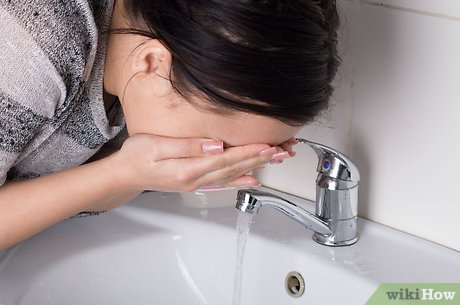

Intent:  The intent of the image is to show a woman washing her hands in a sink, possibly in a bathroom.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to buy jackfruit. The image shows a woman washing her hands in a sink, with a faucet and a sink visible in the scene. There are no objects or context that suggest the intention of the image is related to buying jackfruit.
/content/drive/MyDrive/cs682-project/sample_1/10015565_0_2.jpg


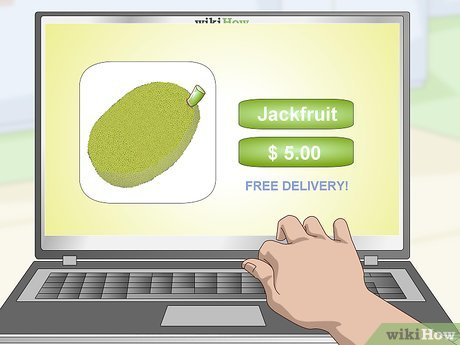

Intent:  The intent of the image is to show a close-up of a person's hand typing on a laptop computer, with a price displayed on the screen. This suggests that the person is likely browsing or shopping online, possibly for a product or service that is being advertised on the screen. The image captures the interaction between the person and the computer, highlighting the process of online shopping or browsing.
Goal step relevance:  Yes, the image depicts a step that is a part of a tutorial on how to buy jackfruit. The image shows a hand on a laptop computer, pointing at a price of $5.00 for a jackfruit. This suggests that the person is looking at the price of the jackfruit, which is an essential step in the process of purchasing the fruit. The image also includes a close-up of the jackfruit, emphasizing its appearance and the price, which can be helpful for someone who is interested in buying jackfruit.
/content/drive/MyDrive/cs682-project/sample_1/10015420_0_2.jpg


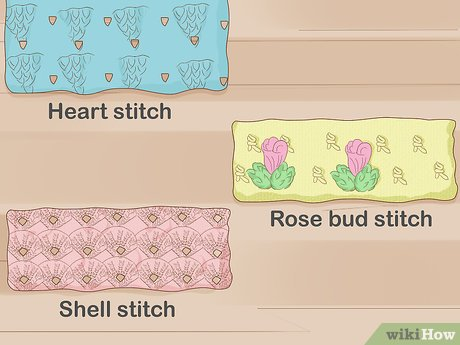

Intent:  The intent of the image is to showcase different types of sewing patterns and stitches, likely for the purpose of inspiring or educating people about various sewing techniques. The image features four different types of sewing patterns, each with a unique stitch, and they are labeled with their respective names. This presentation aims to highlight the variety of stitches and patterns that can be used in sewing projects, potentially to help viewers understand the intricacies of sewing and inspire them to try new techniques.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to buy jackfruit. The image features four different types of pillowcases, each with a different design, and a description of the designs. The designs include a heart stitch, rose bud stitch, shell stitch, and a heart stitch. The image does not provide any information or context related to buying jackfruit.
/content/drive/MyDrive/cs682-project/sampl

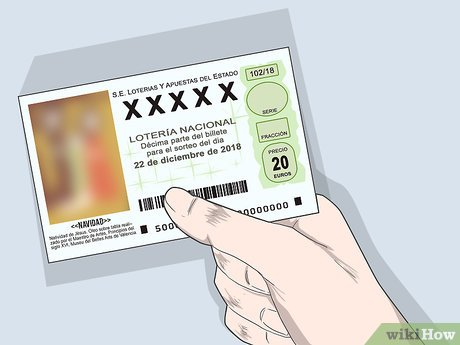

Intent:  The intent of the image is to show a close-up of a hand holding a lottery ticket, possibly to emphasize the importance of the ticket or to illustrate the act of purchasing or checking a lottery ticket.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to buy jackfruit. The image shows a hand holding a ticket or receipt with a barcode, which is not related to the process of buying jackfruit. The focus of the image is on the ticket or receipt and not on the process of purchasing jackfruit.
/content/drive/MyDrive/cs682-project/sample_1/10012730_0_3.jpg


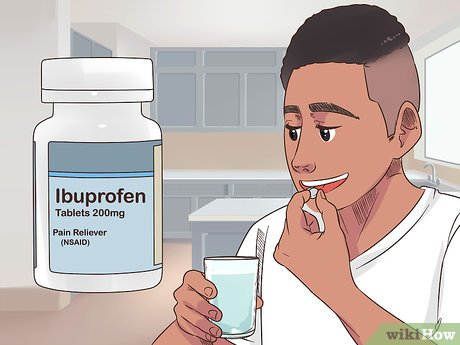

Intent:  The intent of the image is to showcase a man taking a pill, specifically an Advil pain reliever, while smiling. The image is likely meant to convey the idea that the man is happy and comfortable, possibly due to the effectiveness of the Advil pain reliever in alleviating his pain or discomfort. The image may also be used for promotional or educational purposes, highlighting the benefits of using Advil for pain relief.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to buy jackfruit. The image features a man holding a bottle of Advil and a glass of water, with a bottle of pills nearby. The scene is set in a kitchen, and there are cabinets and a sink visible in the background. The image does not provide any information or context related to buying jackfruit.
/content/drive/MyDrive/cs682-project/sample_1/10015565_0_0.jpg


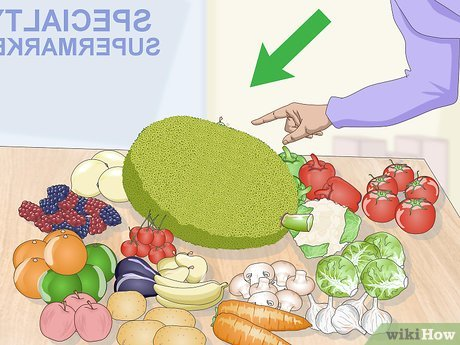

Intent:  The intent of the image is to showcase a variety of fruits and vegetables, with a focus on a large, green, fuzzy fruit that is being pointed at by a person. The image is meant to highlight the different types of produce available and encourage healthy eating habits.
Goal step relevance:  The image does not depict or contribute to a tutorial on how to buy jackfruit. Instead, it features a table filled with various fruits and vegetables, including a large jackfruit, and a person pointing at it. The presence of the person pointing at the jackfruit suggests that they might be drawing attention to its size, shape, or texture, but it does not provide any information on how to buy jackfruit.
/content/drive/MyDrive/cs682-project/sample_1/10015565_0_1.jpg


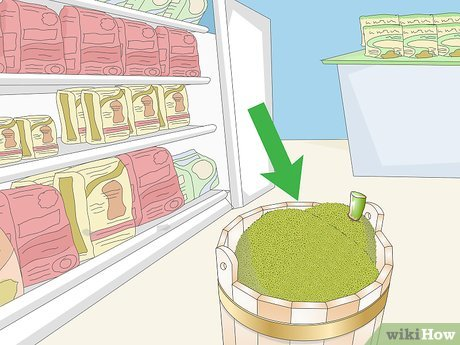

Intent:  The intent of the image is to showcase a creative and unusual way of storing food, using a large wooden barrel or bucket. The barrel is filled with various food items, including a bag of rice, and is placed inside a refrigerator. This setup is meant to be visually appealing and to demonstrate the versatility of using a barrel as a storage container for food items.
Goal step relevance:  Yes, the image depicts a step in a tutorial on how to buy jackfruit. The image shows a bucket of jackfruit sitting on a shelf in front of a refrigerator, which is a common place to store fruits like jackfruit. The presence of the bucket and the refrigerator in the image suggests that the tutorial is providing information on where to store and purchase jackfruit.
/content/drive/MyDrive/cs682-project/sample_1/10015565_2_3.jpg


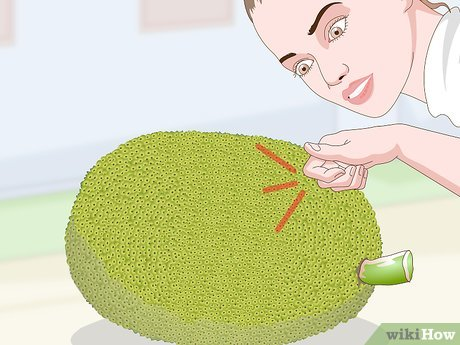

Intent:  The intent of the image is to show a woman interacting with a large, green, round object, possibly a giant marshmallow or a giant ball. She is pointing at the object, possibly indicating its size or shape. The image could be used for various purposes, such as advertising a product, showcasing a unique item, or illustrating a concept related to the object.
Goal step relevance:  Yes, the image depicts a woman holding a green fruit, possibly jackfruit, and pointing at it. This suggests that the image could be a part of a tutorial on how to buy jackfruit, as it demonstrates the appearance and size of the fruit. The woman's action of pointing at the fruit indicates that she is providing information or guidance about the fruit, which is relevant to the tutorial's purpose.
/content/drive/MyDrive/cs682-project/sample_1/10015565_2_4.jpg


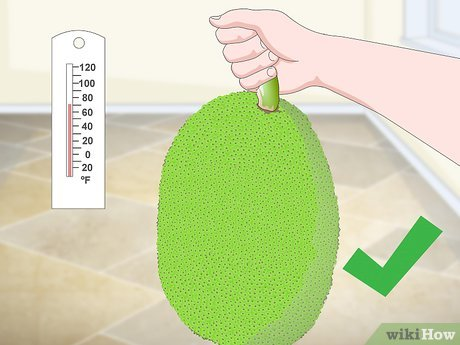

Intent:  The intent of the image is to show a person holding a green object, possibly a fruit or a vegetable, and to provide information about the temperature of the room. The person is holding the object in front of a thermometer, which is used to measure the room's temperature. This combination of elements in the image suggests that the person is trying to determine the appropriate storage conditions for the green object, possibly considering whether it should be stored in a cooler or warmer environment.
Goal step relevance:  Yes, the image depicts a step in the tutorial on how to buy jackfruit. The image shows a person holding a green jackfruit, which is a key component in the process of buying jackfruit. The person is holding the fruit up to a thermometer to determine its freshness, which is an essential step in the buying process. This image provides a visual representation of the importance of checking the freshness of the fruit before purchasing it.
/content/drive/MyDrive/cs682-

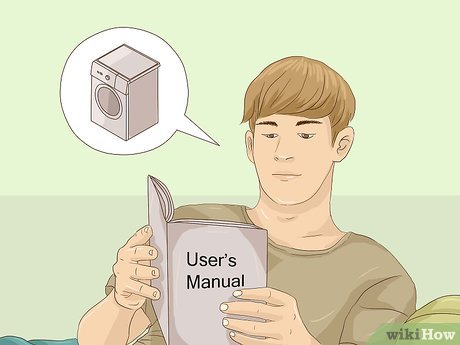

Intent:  The intent of the image is to create a humorous and relatable scene by combining a man reading a book with a laundry machine, which is an unusual combination. The man is holding a book that says "User's Manual" and is reading it while sitting next to a washing machine, which is a play on words and a visual pun. This image is meant to evoke a sense of amusement and curiosity, as it combines two unrelated objects in a single scene.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to buy jackfruit. The image shows a man reading a book, and there is a washing machine in the background. The objects present in the image do not relate to the topic of buying jackfruit.


In [ ]:
folder_path="/content/drive/MyDrive/cs682-project/sample_1"
goal="How to Buy Jackfruit"
for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
          img_path=file_path
          print(img_path)
          img=Image.open(img_path)
          display(img)
          prompt_1="What is the intent of the image?"
          intent=chatbot.start_new_chat(img_path=img_path,prompt=prompt_1)
          print("Intent: ",intent)
          prompt_2="Based on the objects present in the image and intent of the image, does it depict or contribute to a step that is a part of a tutorial of "
          prompt_2_f=prompt_2+goal
          #print(prompt_2_f)
          goal_step_relevance=chatbot.start_new_chat(img_path=img_path,prompt=prompt_2_f)
          print("Goal step relevance: ",goal_step_relevance)

/content/drive/MyDrive/cs682-project/sample_2/1027148_2_0.jpg


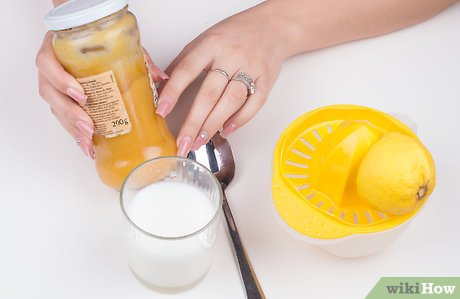

Intent:  The intent of the image is to show a person preparing a meal, specifically making a fruit salad. The person is using a spoon to mix the ingredients in a bowl, and there are other items on the table, such as a glass of milk and a jar of jam. The image captures the process of creating a healthy and delicious fruit salad, highlighting the importance of fresh ingredients and proper food preparation.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to drain a washing machine by hand. The image features a person pouring a liquid into a glass, a bowl, and a lemon, with a spoon and a jar of jam also present. There is no washing machine or any indication of draining a washing machine by hand in the image.
/content/drive/MyDrive/cs682-project/sample_2/1001326_1_0.jpg


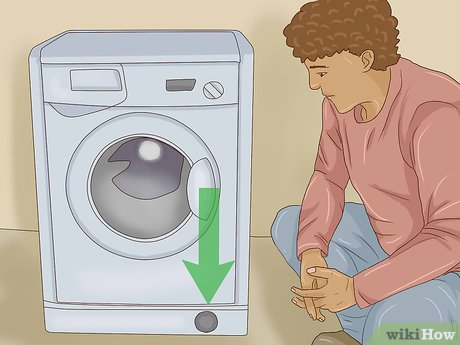

Intent:  The intent of the image is to show a man sitting next to a washing machine, possibly demonstrating how to use the machine or explaining its features.
Goal step relevance:  Yes, the image depicts a step-by-step tutorial on how to drain a washing machine by hand. The man in the image is shown sitting next to a washing machine, and there is a green arrow pointing downwards, which indicates the direction to follow for draining the machine. The presence of the man and the washing machine, along with the arrow, suggests that the image is providing guidance on the process of draining the machine by hand.
/content/drive/MyDrive/cs682-project/sample_2/1001326_1_1.jpg


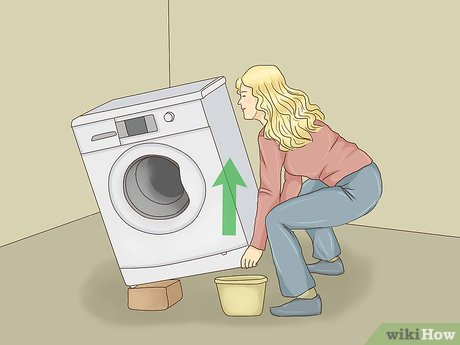

Intent:  The intent of the image is to depict a humorous or comical situation, where a woman is pretending to wash a washing machine, as if it were a dirty dish.
Goal step relevance:  Yes, the image depicts a woman kneeling down next to a washing machine, holding a bucket. This positioning and action suggest that she is attempting to drain the washing machine by hand. The presence of the bucket and the woman's posture indicate that she is following a tutorial or a step-by-step guide on how to drain a washing machine by hand.
/content/drive/MyDrive/cs682-project/sample_2/1001326_1_2.jpg


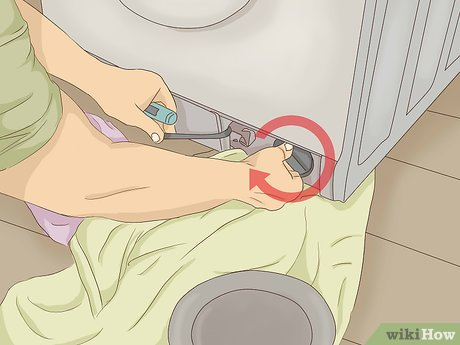

Intent:  The intent of the image is to show a person using an electric toothbrush to clean their teeth.
Goal step relevance:  Yes, the image depicts a person holding a hose or a cord and pointing to a washing machine, which is a step in the tutorial on how to drain a washing machine by hand. The person is likely demonstrating the proper way to connect the hose or cord to the washing machine to drain the water. The presence of the person and the washing machine in the image suggests that it is part of a tutorial or guide on this topic.
/content/drive/MyDrive/cs682-project/sample_2/1001326_1_3.jpg


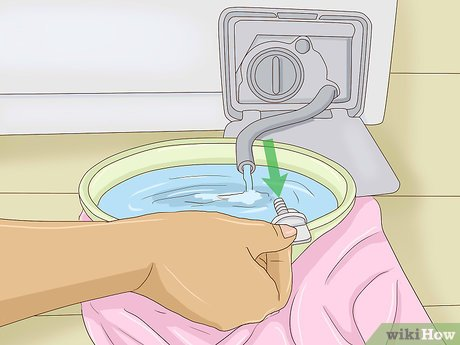

Intent:  The intent of the image is to show a person using a water faucet to fill a container, such as a bucket or a pot, with water.
Goal step relevance:  Yes, the image depicts a step in a tutorial on how to drain a washing machine by hand. The person is shown pouring water into a bowl, which is likely used to collect the water from the washing machine. This step is important in the process of draining the machine, as it helps to remove the water and prevent any overflow or damage to the appliances. The image provides a visual representation of the process and serves as a guide for those who may need to drain their washing machine manually.
/content/drive/MyDrive/cs682-project/sample_2/1001326_0_0.jpg


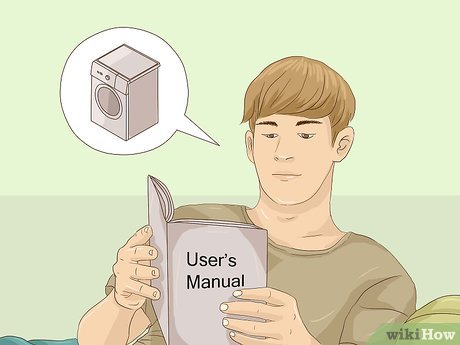

Intent:  The intent of the image is to show a man reading a book while holding a book about a washing machine, possibly a user's manual. The image is meant to convey the idea of learning from a book, even when it is unrelated to the current task at hand.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to drain a washing machine by hand. The image features a man reading a book, with a washing machine and a dryer present in the scene. However, the man is not shown handling the washing machine or dryer, and there is no indication that he is following a tutorial on how to drain a washing machine by hand. The image is focused on the man reading a book, and the objects in the scene do not provide any context or information related to the tutorial.
/content/drive/MyDrive/cs682-project/sample_2/10015602_3_1.jpg


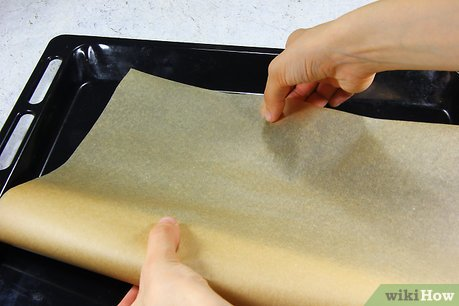

Intent:  The intent of the image is to show a person preparing a piece of parchment paper or plastic wrap by rolling it up or folding it.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to drain a washing machine by hand. The image shows a person's hand holding a piece of plastic or parchment paper, which is not related to draining a washing machine. The focus of the image is on the person's hand and the piece of plastic or parchment paper, rather than providing information on a tutorial on washing machine drainage.
/content/drive/MyDrive/cs682-project/sample_2/10013274_2_1.jpg


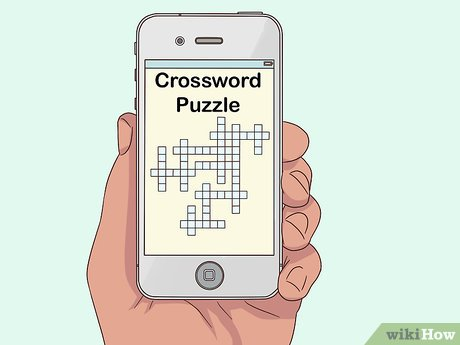

Intent:  The intent of the image is to showcase a person holding a cell phone with a crossword puzzle displayed on the screen.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to drain a washing machine by hand. The image shows a person holding a cell phone with a crossword puzzle displayed on the screen. The presence of a hand and a cell phone does not provide any information or context related to washing machines or draining them by hand.
/content/drive/MyDrive/cs682-project/sample_2/10013274_1_3.jpg


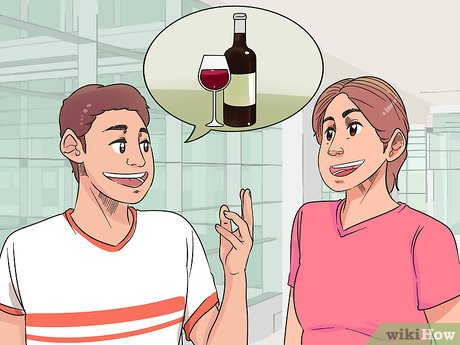

Intent:  The intent of the image is to convey a humorous or lighthearted message by having a cartoon or comic-like illustration of a man and a woman pointing at a wine glass, which is accompanied by a speech bubble. The man and woman are smiling, suggesting a positive and fun atmosphere. The image may be used for entertainment or to convey a message about wine or socializing in a playful manner.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to drain a washing machine by hand. The image features a man and a woman, with a wine glass and a bottle of wine, suggesting a social or celebratory context rather than a tutorial on washing machine maintenance. The objects present in the image do not relate to the process of draining a washing machine by hand.
/content/drive/MyDrive/cs682-project/sample_2/10012735_0_0.jpg


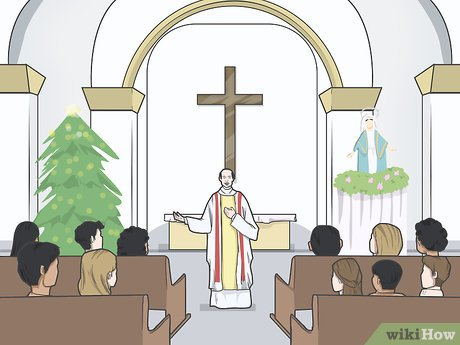

Intent:  The intent of the image is to depict a religious scene, specifically a priest giving a sermon to a congregation in a church. The image features a priest standing at a pulpit, with a cross above him, and a group of people sitting in pews, listening to the sermon. The scene aims to convey the spiritual atmosphere and the role of the priest in leading the congregation during religious services.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to drain a washing machine by hand. The image features a man in a white robe, possibly a priest, standing in front of a congregation and giving a sermon. The presence of a cross and a potted plant in the scene also suggests a religious context, not a washing machine drainage tutorial.
/content/drive/MyDrive/cs682-project/sample_2/10012730_0_4.jpg


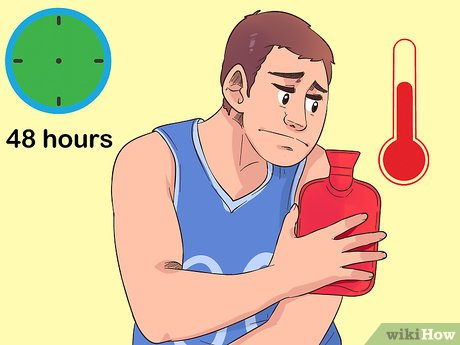

Intent:  The intent of the image is to convey a humorous and relatable message about the challenges of dealing with a cold or flu. The cartoon man is holding a thermometer and a red hot water bottle, which are both commonly used to alleviate cold or flu symptoms. The image is meant to be amusing and light-hearted, as the man's facial expression and body language suggest he is not enjoying the experience of being sick.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to drain a washing machine by hand. The image features a man holding a red thermos, which is not related to the process of draining a washing machine. The image is intended to convey a humorous or comical message, rather than providing instructions or information on a specific task.


In [ ]:
folder_path="/content/drive/MyDrive/cs682-project/sample_2"
goal="How to Drain a Washing Machine by Hand"
for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
          img_path=file_path
          print(img_path)
          img=Image.open(img_path)
          display(img)
          prompt_1="What is the intent of the image?"
          intent=chatbot.start_new_chat(img_path=img_path,prompt=prompt_1)
          print("Intent: ",intent)
          prompt_2="Based on the objects present in the image and intent of the image, does it depict or contribute to a step that is a part of a tutorial of "
          prompt_2_f=prompt_2+goal
          #print(prompt_2_f)
          goal_step_relevance=chatbot.start_new_chat(img_path=img_path,prompt=prompt_2_f)
          print("Goal step relevance: ",goal_step_relevance)

/content/drive/MyDrive/cs682-project/sample_0/1027148_0_0.jpg


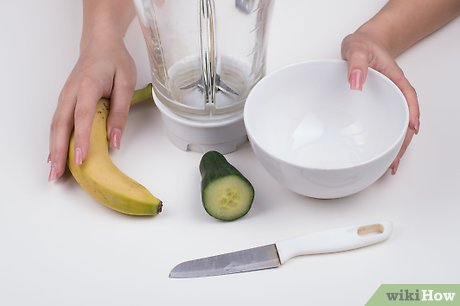

Intent:  The intent of the image is to showcase a person preparing a healthy meal using a blender and a bowl. The person is cutting a banana and a cucumber, which are being used as ingredients in the meal. The image aims to convey the idea of a person making a nutritious and delicious meal using fresh ingredients.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to brighten your skin. The image features a person cutting a banana and a cucumber, along with a white bowl and a blender. These objects are not related to the topic of brightening one's skin. The image is focused on the preparation of a fruit and vegetable dish, rather than providing information on skin care.
/content/drive/MyDrive/cs682-project/sample_0/1027148_0_3.jpg


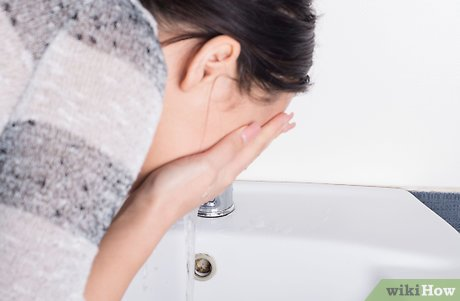

Intent:  The intent of the image is to show a woman washing her face in a sink, possibly in a bathroom.
Goal step relevance:  Yes, the image depicts a woman washing her face in a sink, which is a step in a tutorial on how to brighten your skin. The presence of a faucet and sink in the image suggests that the woman is following a skincare routine, which includes washing her face to remove dirt and impurities. This step is essential for maintaining healthy and bright skin.
/content/drive/MyDrive/cs682-project/sample_0/1027148_0_2.jpg


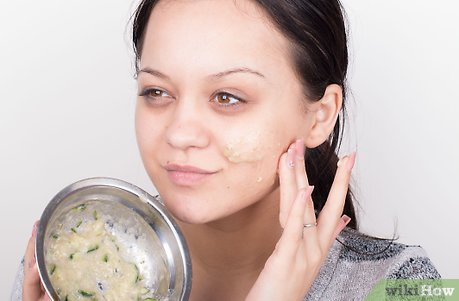

Intent:  The intent of the image is to showcase a woman using a spoon to apply a cream or lotion to her face.
Goal step relevance:  Yes, the image depicts a woman applying a cream to her face using a spoon. This action is a part of a tutorial on how to brighten your skin. The presence of a spoon in the image suggests that the woman is following a specific method or recipe to apply the cream to her face. The image could be a step-by-step guide or an instructional image for others who are interested in learning how to brighten their skin using a similar approach.
/content/drive/MyDrive/cs682-project/sample_0/1027148_0_1.jpg


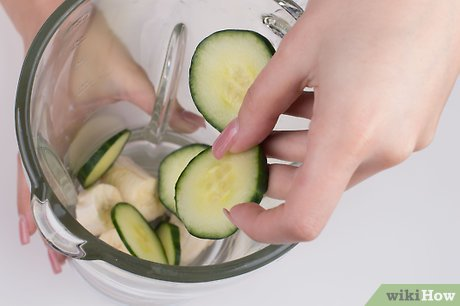

Intent:  The intent of the image is to show a person preparing food, specifically slicing cucumbers, using a food processor or blender.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to brighten your skin. The image shows a person cutting cucumbers into slices and placing them into a container. The focus of the image is on the process of cutting and preparing cucumbers, not on any skin care or brightening techniques.
/content/drive/MyDrive/cs682-project/sample_0/1027148_0_4.jpg


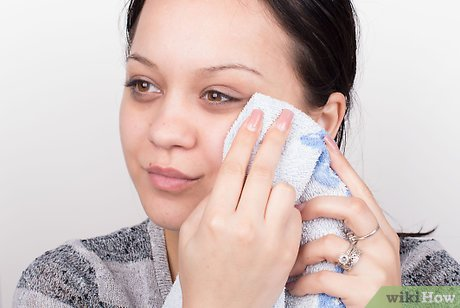

Intent:  The intent of the image is to showcase a woman using a blue towel to wipe her face, possibly after washing her face or applying makeup.
Goal step relevance:  Yes, the image depicts a woman holding a towel with a blue cloth on her face, which is a step in a tutorial on how to brighten your skin. The woman is likely using the cloth to remove excess oil or dirt from her face, which is a part of the process of brightening the skin. The presence of the towel and the cloth suggests that the woman is following a skincare routine or tutorial to improve her skin's appearance.
/content/drive/MyDrive/cs682-project/sample_0/10015420_0_2.jpg


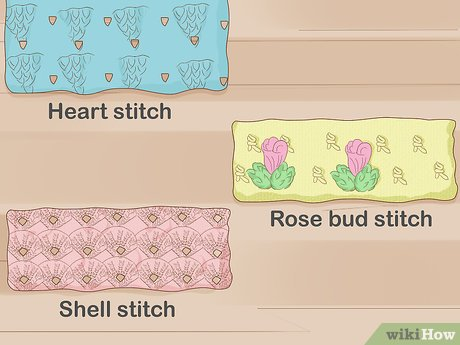

Intent:  The intent of the image is to showcase different types of stitches, specifically heart stitch, shell stitch, and rose bud stitch, by displaying them on a wooden shelf. The image likely serves as a visual guide or reference for those interested in learning or practicing these stitches.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to brighten your skin. The image features three different types of stitches, which are not related to skin brightening. The stitches are described as Heart Stitch, Rose Bud Stitch, and Shell Stitch, and they are presented as a visual aid for understanding the different types of stitches.
/content/drive/MyDrive/cs682-project/sample_0/10012735_0_2.jpg


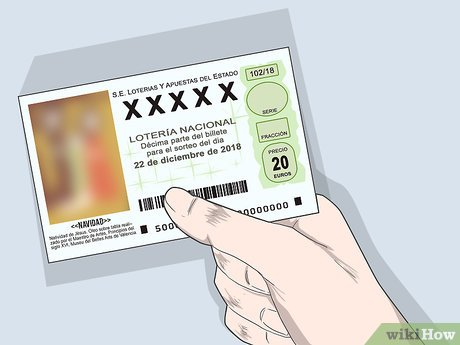

Intent:  The intent of the image is to show a close-up of a hand holding a lottery ticket, possibly to emphasize the importance of the ticket or to draw attention to the ticket's details.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to brighten your skin. The image shows a hand holding a lottery ticket, which is not related to skin brightening. The image focuses on the lottery ticket and the hand holding it, rather than providing information or guidance on skin care or brightening techniques.
/content/drive/MyDrive/cs682-project/sample_0/10012730_0_4.jpg


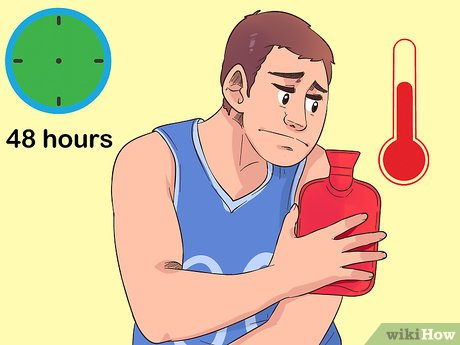

Intent:  The intent of the image is to convey a humorous and relatable situation, as it shows a man holding a thermometer and a bottle of pills, likely to represent a common cold or flu. The man's facial expression and the fact that he is holding a thermometer and pills suggest that he is feeling unwell and possibly dealing with a cold or flu. The image is meant to be amusing and entertaining, as it presents a light-hearted and comical take on a common, everyday situation.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to brighten your skin. The image features a man holding a red thermos, which is not related to skin brightening. The presence of a clock in the image suggests that it might be related to time management or a work-related context, but it does not provide any information or guidance on skin brightening.
/content/drive/MyDrive/cs682-project/sample_0/10015160_1_0.jpg


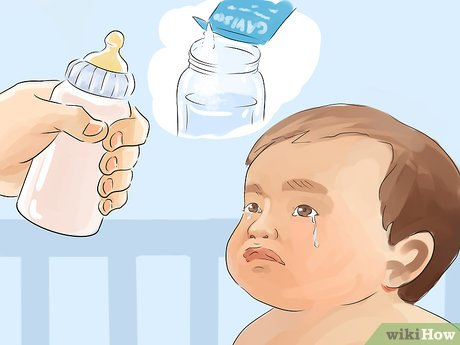

Intent:  The intent of the image is to depict a humorous or satirical situation, where a baby is shown crying while an adult is feeding it with a bottle. The baby's sad expression and the adult's actions create a comical contrast between the baby's emotions and the adult's caregiving behavior. The image may also be interpreted as a commentary on the challenges faced by parents in caring for their children.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to brighten your skin. The image features a baby with a bottle, a cup, and a bottle of lotion. There is no direct connection between these objects and the process of brightening one's skin. The image's focus is on the baby and the caregiving aspect, rather than providing information on skincare.
/content/drive/MyDrive/cs682-project/sample_0/10013274_0_3.jpg


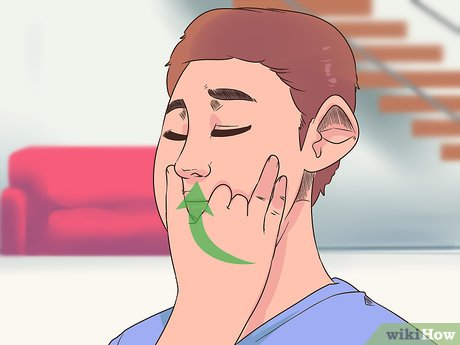

Intent:  The intent of the image is to depict a person with a green crescent moon on their hand, possibly as a symbol or a gesture. The person is also making a funny face, which adds a humorous element to the scene. The image may be intended to convey a lighthearted or playful message, or it could be used in a creative context, such as an advertisement or a social media post.
Goal step relevance:  The image does not depict or contribute to a step that is a part of a tutorial on how to brighten your skin. The image features a man with a green crescent moon on his hand, which is not related to skin brightening. The primary focus of the image is the green crescent moon, not the process of brightening one's skin.


In [ ]:
folder_path="/content/drive/MyDrive/cs682-project/sample_0"
goal="How to Brighten Your Skin"
for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
          img_path=file_path
          print(img_path)
          img=Image.open(img_path)
          display(img)
          prompt_1="What is the intent of the image?"
          intent=chatbot.start_new_chat(img_path=img_path,prompt=prompt_1)
          print("Intent: ",intent)
          prompt_2="Based on the objects present in the image and intent of the image, does it depict or contribute to a step that is a part of a tutorial of "
          prompt_2_f=prompt_2+goal
          #print(prompt_2_f)
          goal_step_relevance=chatbot.start_new_chat(img_path=img_path,prompt=prompt_2_f)
          print("Goal step relevance: ",goal_step_relevance)

/content/drive/MyDrive/cs682-project/sample_3/100021_1_0.jpeg


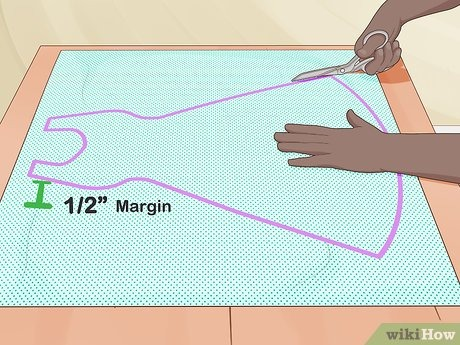

Intent:  The intent of the image is to show a person measuring a piece of fabric or material on a table, possibly for sewing or crafting purposes.
Goal step relevance:  Yes, the image depicts a step in a tutorial on how to make a dress. The person is cutting out a pattern on a piece of fabric using a pair of scissors, which is a crucial step in the dress-making process. The image shows the person's hands holding the scissors and the fabric, indicating that they are actively engaged in the process of cutting out the pattern. This action is essential for creating a well-fitted dress and ensuring that the fabric is used efficiently. The presence of the scissors and the fabric in the image clearly illustrates the cutting step in the dress-making process.
/content/drive/MyDrive/cs682-project/sample_3/100021_1_4.jpeg


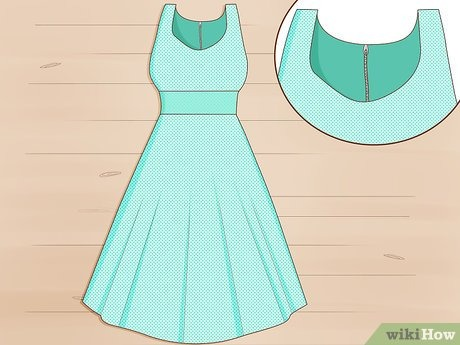

Intent:  The intent of the image is to showcase a blue dress, likely a prom dress, by providing a detailed view of the dress's design and color. The dress is depicted in a polka dot pattern, which adds to its visual appeal. The image is accompanied by a diagram or a pattern, possibly indicating the dress's structure or design elements. This visual representation of the dress can be helpful for potential buyers, designers, or anyone interested in the dress's features and appearance.
Goal step relevance:  Yes, the image depicts a step in a tutorial on how to make a dress. The image shows a dress pattern, a dressmaker's dummy, and a dressmaker's measuring tape. These objects are commonly used in the process of creating a dress, and their presence in the image indicates that it is a tutorial or guide on how to make a dress. The dressmaker's dummy and measuring tape are essential tools for accurately measuring and fitting a dress, while the dress pattern provides a template for creating the

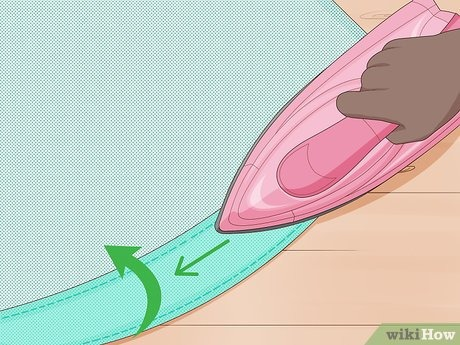

Intent:  The intent of the image is to demonstrate how to use a sewing machine to create a curved seam or a curved seam allowance. The image shows a person using a pink sewing machine to create a curved seam on a piece of fabric. The person is following the instructions, which are likely to be written on the fabric, to ensure the seam is properly created. The image aims to provide guidance and inspiration to those who want to learn how to use a sewing machine for creating curved seams.
Goal step relevance:  Yes, the image depicts a step that is a part of a tutorial on how to make a dress. The image shows a person using a pink pair of scissors to cut a piece of fabric, which is a crucial step in the process of making a dress. The presence of the scissors and the act of cutting the fabric indicate that the image is providing information on a specific action or technique involved in the dress-making process.
/content/drive/MyDrive/cs682-project/sample_3/100021_1_1.jpeg


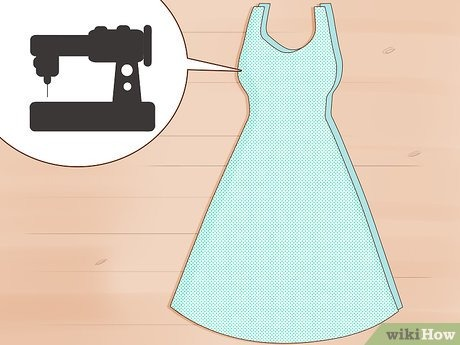

Intent:  The intent of the image is to showcase a dress pattern or design, possibly for a sewing project or as a visual aid for someone learning how to sew. The image features a dress pattern or design displayed on a wooden surface, with a sewing machine nearby, suggesting that the dress is being created or has been created using the sewing machine. The image may also be used to demonstrate the process of creating a dress or to provide inspiration for someone looking to create their own dress.
Goal step relevance:  Yes, the image depicts a step that is a part of a tutorial on how to make a dress. The image shows a dress pattern, a sewing machine, and a dressmaker's mannequin. These elements are commonly used in the process of creating a dress, and the presence of the pattern and the mannequin suggest that the image is providing information on the dressmaking process. The sewing machine is also an essential tool for creating a dress, and its presence in the image further supports the id

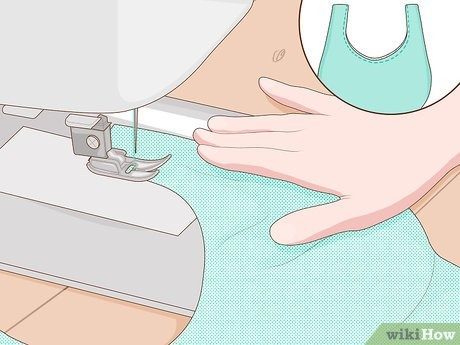

Intent:  The intent of the image is to show a close-up view of a person's hand holding a needle and thread, possibly while sewing or embroidering. The image is in a comic book style, which adds a creative and artistic touch to the scene.
Goal step relevance:  Yes, the image depicts a step in a tutorial on how to make a dress. The image shows a person's hand holding a needle and thread, which are essential tools for sewing a dress. The presence of a dress pattern and a piece of fabric further supports the idea that the image is part of a tutorial on dressmaking. The person's hand is also shown holding a piece of fabric, which is another essential component of the dressmaking process.
/content/drive/MyDrive/cs682-project/sample_3/10012735_4_1.jpg


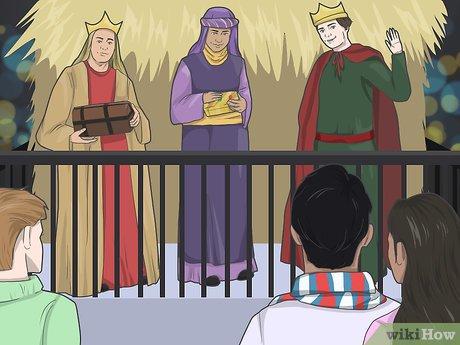

Intent:  The intent of the image is to depict a scene where three people dressed in medieval costumes are standing in front of a crowd of people, possibly performing or entertaining them. The medieval costumes and the presence of a crowd suggest that the image is meant to evoke a sense of historical or cultural significance, possibly related to a medieval-themed event or performance.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to make a dress. The image features three people dressed in medieval costumes, with one of them holding a book. The setting appears to be a stage, and there is a fence in the background. The presence of the book and the medieval costumes suggest that the scene might be related to a theatrical performance or a historical reenactment, rather than a tutorial on making a dress.
/content/drive/MyDrive/cs682-project/sample_3/10012730_2_4.jpg


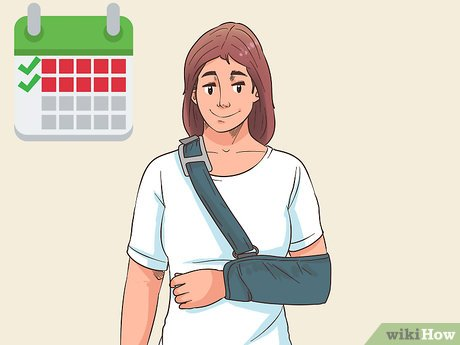

Intent:  The intent of the image is to show a woman with a broken arm, likely as a result of an accident or injury. The woman is wearing a sling to support her arm, and she is smiling, indicating that she is in good spirits despite the situation. The image serves as a reminder of the importance of taking care of oneself and being prepared for unexpected events.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to make a dress. The image features a woman wearing a white shirt and a blue purse, standing next to a calendar. The presence of a calendar and a purse does not provide any context or information related to making a dress.
/content/drive/MyDrive/cs682-project/sample_3/10012735_0_2.jpg


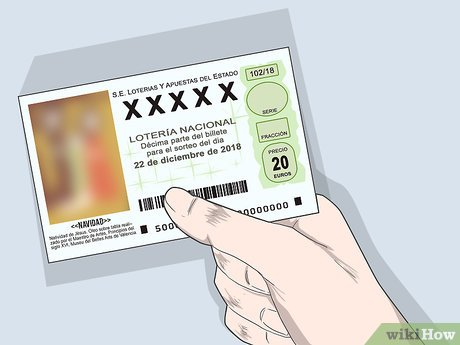

Intent:  The intent of the image is to show a close-up of a hand holding a lottery ticket, highlighting the ticket's features and the person's interaction with it.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to make a dress. The image features a hand holding a lottery ticket, which is not related to the process of making a dress. The objects present in the image are focused on the lottery ticket and not on any dress-making process.
/content/drive/MyDrive/cs682-project/sample_3/10015761_0_2.jpg


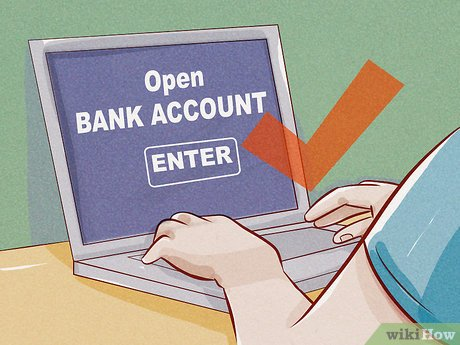

Intent:  The intent of the image is to illustrate a person using a laptop computer to access their bank account. The person is clicking on the "Enter" button, which is a common action when interacting with a computer system, such as logging into a bank account. The image aims to convey the idea of online banking and the ease with which users can access their financial information through digital devices.
Goal step relevance:  No, the image does not depict or contribute to a step that is a part of a tutorial on how to make a dress. The image features a person using a laptop, with a mouse and keyboard visible, and a hand on the mouse. The laptop screen displays the word "Open Bank Account Enter," which suggests that the person is opening a bank account. This is not related to making a dress, and the image does not provide any context or information about dress-making.


In [ ]:
folder_path="/content/drive/MyDrive/cs682-project/sample_3"
goal="How to Make a Dress"
for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
          img_path=file_path
          print(img_path)
          img=Image.open(img_path)
          display(img)
          prompt_1="What is the intent of the image?"
          intent=chatbot.start_new_chat(img_path=img_path,prompt=prompt_1)
          print("Intent: ",intent)
          prompt_2="Based on the objects present in the image and intent of the image, does it depict or contribute to a step that is a part of a tutorial of "
          prompt_2_f=prompt_2+goal
          #print(prompt_2_f)
          goal_step_relevance=chatbot.start_new_chat(img_path=img_path,prompt=prompt_2_f)
          print("Goal step relevance: ",goal_step_relevance)

# Test to carry forward context from the previously seen images

In [ ]:
context=""
for index in range(len(list_images)):
  img_path="/content/"+list_images[index]
  if index==0:
    print(img_path)
    ans=chatbot.start_new_chat(img_path=img_path,prompt="what is the intent of this image?")
    context=ans
    print("first desc",context)
  else:
    print(img_path)
    prompt="what is the intent of this image?"
    ans=chatbot.start_new_chat(img_path=img_path,prompt=prompt)
    print(ans)
    prompt_new="Given the current image and its associated intent "+ans+", please analyze the context "+context+" provided by the intents of the images seen before this one, separated by ';'. Check if there is any discernible correlation or pattern between the intents. If such a correlation exists, update the current answer (ans) accordingly. Consider the possibility that these correlations might collectively indicate a goal or direction. Provide a comprehensive analysis of how the intents may be interconnected and how they contribute to an overall narrative or objective."
    ans_updated=chatbot.continue_chat(prompt=prompt_new)
    print(ans_updated)
    context=context+";"+ans
    print(context)


# Step ordering

In [ ]:
from transformers import AutoTokenizer
import transformers
import torch

model = "meta-llama/Llama-2-7b-chat-hf" # meta-llama/Llama-2-7b-hf

tokenizer = AutoTokenizer.from_pretrained(model, use_auth_token=True)

In [ ]:
from transformers import pipeline

llama_pipeline = pipeline(
    "text-generation",  # LLM task
    model=model,
    torch_dtype=torch.float16,
    device_map="auto",
)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def get_llama_response(prompt: str) -> None:
    """
    Generate a response from the Llama model.

    Parameters:
        prompt (str): The user's input/question for the model.

    Returns:
        None: Prints the model's response.
    """
    sequences = llama_pipeline(
        prompt,
        do_sample=True,
        top_k=10,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        max_length=1000,
    )
    print("Chatbot:", sequences[0]['generated_text'])



prompt = """
Return all the steps only from the list of steps given below that might lead upto the goal of "How to Brighten Your Skin".
Options:

"""
print(get_llama_response(prompt))